In [ ]:
!pip install cleverhans

In [ ]:
import tensorflow as tf
import numpy as np
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
# Load a pretrained ResNet50 model
model = ResNet50(weights='imagenet', classifier_activation=None)


model.trainable = False

In [ ]:
# Load and preprocess the image
img_path = '/content/dog.webp'
img = image.load_img(img_path, target_size=(224, 224))
input_tensor = image.img_to_array(img)
input_tensor = np.expand_dims(input_tensor, axis=0)
input_tensor = preprocess_input(input_tensor)  # Preprocess the image as required by ResNet50

# Get the model's prediction on the original image
original_preds = model.predict(input_tensor)
original_label= np.argmax(original_preds[0])
print(f'Original Prediction: {decode_predictions(original_preds, top=1)[0][0]}')

# Define the model function for the attack
def model_fn(x):
    logits = model(x)
    return logits

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Original Prediction: ('n02099601', 'golden_retriever', 15.266423)


In [ ]:
# Set the attack parameters
eps = 0.1  # Maximum perturbation
eps_iter = 0.01  # Step size per iteration
nb_iter = 20  # Number of attack iterations
norm = np.inf  # Use the infinity norm
clip_min = -1.0  # Minimum input value after preprocessing
clip_max = 1.0   # Maximum input value after preprocessing
targeted = False  # Untargeted attack

# Get the true label and ensure it's an integer tensor
y_true = tf.convert_to_tensor([original_label], dtype=tf.int32)
print(f'y_true: {y_true}')
print(f'y_true shape: {y_true.shape}')
print(f'y_true dtype: {y_true.dtype}')

y_true: [207]
y_true shape: (1,)
y_true dtype: <dtype: 'int32'>


In [ ]:
# Run the Basic Iterative Method attack
adv_x = basic_iterative_method(
    model_fn=model_fn,
    x=input_tensor,
    eps=eps,
    eps_iter=eps_iter,
    nb_iter=nb_iter,
    norm=norm,
    clip_min=clip_min,
    clip_max=clip_max,
    y=y_true,
    targeted=targeted,
    rand_init=False,
    rand_minmax=eps,
    sanity_checks=False,  # Disable sanity checks
)

# Get the model's prediction on the adversarial example
adv_preds = model.predict(adv_x)
adv_label = np.argmax(adv_preds[0])
print(f'Adversarial Prediction: {decode_predictions(adv_preds, top=1)[0][0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Adversarial Prediction: ('n04404412', 'television', 4.5782332)


In [ ]:
# Reverse preprocessing to display the adversarial image
def deprocess_image(x):
    x = x.copy()
    # ResNet50 preprocesses inputs to [0, 255] range, so reverse this
    x /= 2.0  # Reverse ResNet50 scaling to [-1, 1] range
    x += 0.5
    x *= 255
    x = np.clip(x, 0, 255).astype(np.uint8)
    return x

# Prepare images for display
original_img = deprocess_image(input_tensor[0])
adv_img = deprocess_image(adv_x.numpy()[0])

# Save the adversarial image
adv_img_pil = image.array_to_img(adv_img)
adv_img_pil.save('adv_bim_sample.jpg')
print('Adversarial image saved as adv_bim_sample.jpg')

Adversarial image saved as adv_bim_sample.jpg


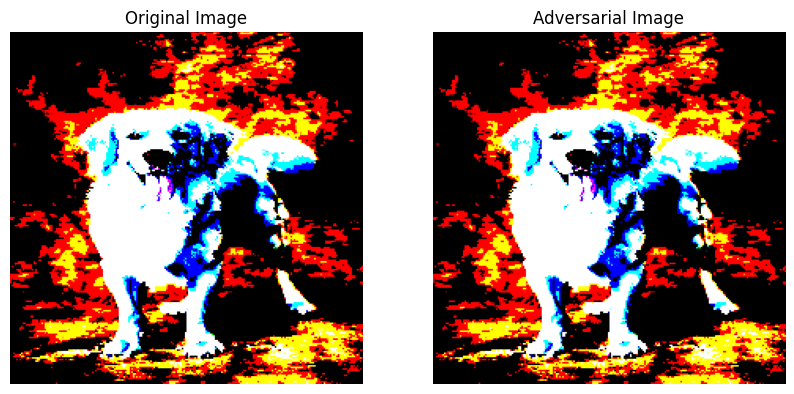

In [ ]:
# Display the original and adversarial images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title('Adversarial Image')
plt.axis('off')

plt.show()